In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/translation/_about.txt
/kaggle/input/translation/mal.txt


In [2]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, RepeatVector
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_colwidth', 200)

In [3]:
import re
import pandas as pd
from numpy import array
import string
# function to read raw text file
def read_text(filename):
        # open the file
        file = open(filename, mode='rt', encoding='utf-8')
        
        # read all text
        text = file.read()
        file.close()
        return text
# Let’s define another function to split the text into English-German pairs separated by ‘\n’. We’ll then split these pairs into English sentences and German sentences respectively.
# split a text into sentences

def to_lines(text):
      sents = text.strip().split('\n')
      sents = [i.split('\t') for i in sents]
      return sents

#We can now use these functions to read the text into an array in our desired format.

data = read_text("/kaggle/input/translation/mal.txt")
deu_eng = to_lines(data)
deu_eng = array(deu_eng)


deu_eng = deu_eng[:50000,:2]
print(data[0:175])
deu_eng

Hello.	നമസ്കാരം.	CC-BY 2.0 (France) Attribution: tatoeba.org #1858850 (LanguageExpert) & #651913 (jjrodz)
Really?	ശരിക്കും?	CC-BY 2.0 (France) Attribution: tatoeba.org #373216


array([['Hello.', 'നമസ്കാരം.'],
       ['Really?', 'ശരിക്കും?'],
       ['Help me.', 'എന്നെ സഹായിക്കൂ.'],
       ...,
       ["I don't think that you need to tell Tom why you went Australia.",
        'നീ എന്തിനാണ് ഓസ്ട്രേലിയയില്\u200d പോയതെന്ന് ടോമിനോട് പറയണ്ട കാര്യമുണ്ടെന്നു എനിക്ക് തോന്നുന്നില്ല.'],
       ['The pyramids of Egypt are one of the seven wonders of the world.',
        'ഈജിപ്തിലെ പിരമിഡുകൾ ലോകത്തിലെ ഏഴ് അത്ഭുതങ്ങളിൽ ഒന്നാണ്.'],
       ['If you had left home a little earlier you would have been in time.',
        'നീ വീട്ടിൽ നിന്ന് കുറച്ച് നേരത്തെ പുറപ്പെട്ടിരുന്നുവെങ്കിൽ നിനക്ക് സമയത്ത് എത്താമായിരുന്നു.']],
      dtype='<U93')

In [4]:
# Remove punctuation
deu_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,0]]
deu_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,1]]

deu_eng[:,:2]

array([['Hello', 'നമസ്കാരം'],
       ['Really', 'ശരിക്കും'],
       ['Help me', 'എന്നെ സഹായിക്കൂ'],
       ...,
       ['I dont think that you need to tell Tom why you went Australia',
        'നീ എന്തിനാണ് ഓസ്ട്രേലിയയില്\u200d പോയതെന്ന് ടോമിനോട് പറയണ്ട കാര്യമുണ്ടെന്നു എനിക്ക് തോന്നുന്നില്ല'],
       ['The pyramids of Egypt are one of the seven wonders of the world',
        'ഈജിപ്തിലെ പിരമിഡുകൾ ലോകത്തിലെ ഏഴ് അത്ഭുതങ്ങളിൽ ഒന്നാണ്'],
       ['If you had left home a little earlier you would have been in time',
        'നീ വീട്ടിൽ നിന്ന് കുറച്ച് നേരത്തെ പുറപ്പെട്ടിരുന്നുവെങ്കിൽ നിനക്ക് സമയത്ത് എത്താമായിരുന്നു']],
      dtype='<U93')

In [5]:
for i in range(len(deu_eng)):
    deu_eng[i,0] = deu_eng[i,0].lower()
    deu_eng[i,1] = deu_eng[i,1].lower()

deu_eng

array([['hello', 'നമസ്കാരം'],
       ['really', 'ശരിക്കും'],
       ['help me', 'എന്നെ സഹായിക്കൂ'],
       ...,
       ['i dont think that you need to tell tom why you went australia',
        'നീ എന്തിനാണ് ഓസ്ട്രേലിയയില്\u200d പോയതെന്ന് ടോമിനോട് പറയണ്ട കാര്യമുണ്ടെന്നു എനിക്ക് തോന്നുന്നില്ല'],
       ['the pyramids of egypt are one of the seven wonders of the world',
        'ഈജിപ്തിലെ പിരമിഡുകൾ ലോകത്തിലെ ഏഴ് അത്ഭുതങ്ങളിൽ ഒന്നാണ്'],
       ['if you had left home a little earlier you would have been in time',
        'നീ വീട്ടിൽ നിന്ന് കുറച്ച് നേരത്തെ പുറപ്പെട്ടിരുന്നുവെങ്കിൽ നിനക്ക് സമയത്ത് എത്താമായിരുന്നു']],
      dtype='<U93')

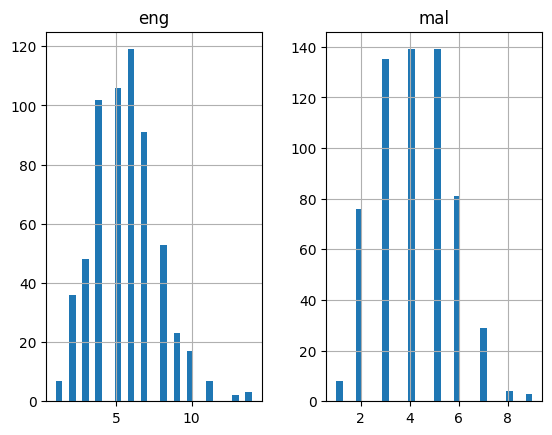

In [6]:
eng_l = []
mal_l = []

for i in deu_eng[:,0]:
      eng_l.append(len(i.split()))

for i in deu_eng[:,1]:
      mal_l.append(len(i.split()))

length_df = pd.DataFrame({'eng':eng_l, 'mal':mal_l})

length_df.hist(bins = 30)
plt.show()

In [7]:
def tokenization(lines):
      tokenizer = Tokenizer()
      tokenizer.fit_on_texts(lines)
      return tokenizer

In [8]:
# prepare english tokenizer
eng_tokenizer = tokenization(deu_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 986


In [9]:
# prepare Deutch tokenizer
deu_tokenizer = tokenization(deu_eng[:, 1])
deu_vocab_size = len(deu_tokenizer.word_index) + 1

deu_length = 8
print('Deutch Vocabulary Size: %d' % deu_vocab_size)

Deutch Vocabulary Size: 1418


In [10]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
     # integer encode sequences
     seq = tokenizer.texts_to_sequences(lines)
     # pad sequences with 0 values
     seq = pad_sequences(seq, maxlen=length, padding='post')
     return seq

In [11]:
from sklearn.model_selection import train_test_split

# split data into train and test set
train, test = train_test_split(deu_eng, test_size=0.2, random_state = 12)

In [43]:
# prepare training data
trainX = encode_sequences(eng_tokenizer, deu_length, train[:, 1])
trainY = encode_sequences(deu_tokenizer, eng_length, train[:, 0])

# prepare validation data
testX = encode_sequences(eng_tokenizer, deu_length, test[:, 1])
testY = encode_sequences(deu_tokenizer, eng_length, test[:, 0])

print(trainX.shape)

(491, 8)


In [13]:
# build NMT model
def define_model(in_vocab,out_vocab, in_timesteps,out_timesteps,units):
      model = Sequential()
      model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
      model.add(LSTM(units))
      model.add(RepeatVector(out_timesteps))
      model.add(LSTM(units, return_sequences=True))
      model.add(Dense(out_vocab, activation='softmax'))
      return model

In [14]:
# model compilation
model = define_model(deu_vocab_size, eng_vocab_size, deu_length, eng_length, 512)
rms = optimizers.RMSprop(learning_rate=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [16]:
filename = 'model.h1.24_jan_19.keras'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# train model
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                    epochs=30, batch_size=512, validation_split = 0.2,callbacks=[checkpoint], 
                    verbose=1)

Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 6.8534
Epoch 1: val_loss improved from inf to 6.81669, saving model to model.h1.24_jan_19.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 6.8534 - val_loss: 6.8167
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 6.8167
Epoch 2: val_loss improved from 6.81669 to 6.77410, saving model to model.h1.24_jan_19.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 6.8167 - val_loss: 6.7741
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 6.7741
Epoch 3: val_loss improved from 6.77410 to 6.71920, saving model to model.h1.24_jan_19.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 6.7741 - val_loss: 6.7192
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 6.7192
Epoch 4: val_loss improved from 6.71920 to 6.63946, saving model to model.h1.24_jan_19.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 6.7192 - val_loss: 6.6395
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 6.6395
Epoch 5: val_loss improved from 6.63946 to

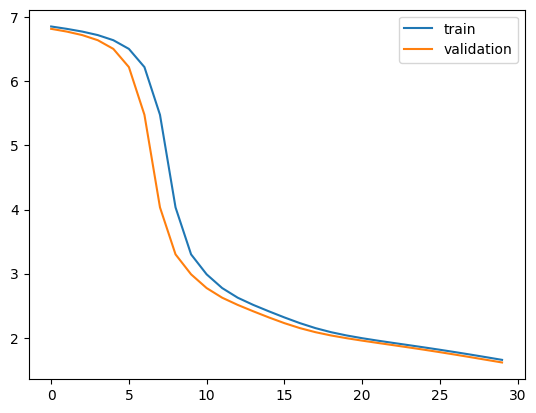

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [38]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
            pass
    return word

In [48]:
model = load_model('model.h1.24_jan_19.keras')
preds = model.predict(testX.reshape((testX.shape[0],testX.shape[1])))

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step


array([[[1.60816358e-03, 1.01664511e-03, 1.00921746e-03, ...,
         1.01183972e-03, 1.00994972e-03, 1.01937109e-03],
        [5.89461997e-03, 1.02369906e-03, 9.85882129e-04, ...,
         1.00155245e-03, 9.90798464e-04, 1.03924668e-03],
        [2.56941527e-01, 7.87896803e-04, 6.90651068e-04, ...,
         7.33470020e-04, 7.04323582e-04, 8.35592975e-04],
        ...,
        [9.99999940e-01, 3.62289165e-13, 2.05590373e-13, ...,
         2.87191278e-13, 2.36808674e-13, 5.30016948e-13],
        [9.99999940e-01, 2.15248487e-14, 1.13979057e-14, ...,
         1.65730077e-14, 1.33965765e-14, 3.22785588e-14],
        [9.99999940e-01, 6.57449440e-15, 3.36841773e-15, ...,
         4.98555334e-15, 4.00032358e-15, 9.92797577e-15]],

       [[1.60816358e-03, 1.01664511e-03, 1.00921746e-03, ...,
         1.01183972e-03, 1.00994972e-03, 1.01937109e-03],
        [5.89461997e-03, 1.02369906e-03, 9.85882129e-04, ...,
         1.00155245e-03, 9.90798464e-04, 1.03924668e-03],
        [2.56941527e-01, 

In [40]:
preds_text = []
for i in preds:
   temp = []
   for j in range(len(i)):
        t = get_word(np.argmax(i[j]), deu_tokenizer)
        if j > 0:
            if (t == get_word(np.argmax(i[j]), deu_tokenizer)) or (t == None):
                 temp.append('')
            else:
                 temp.append(t)
        else:
               if(t == None):
                      temp.append('')
               else:
                      temp.append(t) 

   preds_text.append(' '.join(temp))

In [41]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})

In [42]:
# print 15 rows randomly
pred_df.sample(15)

,actual,predicted
91,what do you like to do,എത്താമായിരുന്നു
108,he weighs 70 kilos,എത്താമായിരുന്നു
2,i will gladly help you,എത്താമായിരുന്നു
66,four multiplied by two is eight,എത്താമായിരുന്നു
13,we stayed there for three months,എത്താമായിരുന്നു
107,he cannot write english without making mistakes,എത്താമായിരുന്നു
33,thats acceptable,എത്താമായിരുന്നു
5,things went back to normal,എത്താമായിരുന്നു
83,youre smarter than tom is,എത്താമായിരുന്നു
116,i came to japan two years ago,എത്താമായിരുന്നു


In [28]:
deu_tokenizer.word_index

{'എനിക്ക്': 1,
 'ഞാൻ': 2,
 'ഒരു': 3,
 'ഞാന്\u200d': 4,
 'ഈ': 5,
 'അവൻ': 6,
 'എന്റെ': 7,
 'അത്': 8,
 'ആ': 9,
 'ടോം': 10,
 'കഴിയും': 11,
 'നീ': 12,
 'അവൾ': 13,
 'എന്ന്': 14,
 'ഇത്': 15,
 'ആണ്': 16,
 'എന്നെ': 17,
 'അവന്': 18,
 'നിനക്ക്': 19,
 'അവനെ': 20,
 'വളരെ': 21,
 'അവന്\u200d': 22,
 'അവളുടെ': 23,
 'നിങ്ങള്\u200dക്ക്': 24,
 'ഇഷ്ടമാണ്': 25,
 'നിങ്ങള്\u200d': 26,
 'അവള്\u200d': 27,
 'അവർ': 28,
 'എന്താണ്': 29,
 'രണ്ട്': 30,
 'മുമ്പ്': 31,
 'ദയവായി': 32,
 'ഇവിടെ': 33,
 'നിങ്ങളുടെ': 34,
 'വീട്ടിൽ': 35,
 'മൂന്ന്': 36,
 'അവന്റെ': 37,
 'ഇംഗ്ലീഷ്': 38,
 'ഇന്ന്': 39,
 'നിന്റെ': 40,
 'നല്ല': 41,
 'തരാന്\u200d': 42,
 'നാളെ': 43,
 'മഴ': 44,
 'ഉണ്ട്': 45,
 'അറിയാം': 46,
 'ടോമിന്': 47,
 'ടോമിനെ': 48,
 'പോയി': 49,
 'എവിടെയാണ്': 50,
 'ജോലി': 51,
 'ഞങ്ങൾ': 52,
 'വളരെയധികം': 53,
 'പുസ്തകം': 54,
 'രണ്ടു': 55,
 'ഇന്നലെ': 56,
 'ഇപ്പോൾ': 57,
 'സമയം': 58,
 'നിങ്ങൾ': 59,
 'ചോദിച്ചു': 60,
 'നിന്ന്': 61,
 'ആരും': 62,
 'അവര്\u200d': 63,
 'തവണ': 64,
 'അറിയില്ല': 65,
 'തോന്നുന്നില്ല': 66,
 'കൊണ്ട്': 67,
 'തിരിച്ചു'

In [51]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense
import numpy as np

# Step 1: Load and preprocess the data
def load_data(file_path):
    english_sentences = []
    malayalam_sentences = []
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            if '\t' in line:
                en, ml, _ = line.split('\t')
                english_sentences.append(en.strip())
                malayalam_sentences.append(ml.strip())
    return english_sentences, malayalam_sentences

# Load the dataset
file_path = "/kaggle/input/translation/mal.txt"  # Replace with the actual path to your file
english_sentences, malayalam_sentences = load_data(file_path)

# Step 2: Tokenization
def tokenize(sentences, max_num_words=None, max_sequence_length=None):
    tokenizer = Tokenizer(num_words=max_num_words, filters='')
    tokenizer.fit_on_texts(sentences)
    sequences = tokenizer.texts_to_sequences(sentences)
    padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length, padding='post')
    return tokenizer, padded_sequences

# Parameters
MAX_NUM_WORDS = 10000  # Maximum vocabulary size
MAX_SEQUENCE_LENGTH = 20  # Maximum sentence length

# Tokenize English and Malayalam sentences
en_tokenizer, en_sequences = tokenize(english_sentences, MAX_NUM_WORDS, MAX_SEQUENCE_LENGTH)
ml_tokenizer, ml_sequences = tokenize(malayalam_sentences, MAX_NUM_WORDS, MAX_SEQUENCE_LENGTH)

# Prepare inputs and outputs for the model
encoder_input_data = en_sequences
decoder_input_data = ml_sequences[:, :-1]  # Exclude the last word
decoder_target_data = ml_sequences[:, 1:]  # Exclude the first word

# Step 3: Build the Seq2Seq model
EMBEDDING_DIM = 256
LATENT_DIM = 512

# Encoder
encoder_inputs = Input(shape=(None,))
enc_emb = Embedding(input_dim=len(en_tokenizer.word_index) + 1, output_dim=EMBEDDING_DIM)(encoder_inputs)
encoder_lstm = LSTM(LATENT_DIM, return_state=True)
_, state_h, state_c = encoder_lstm(enc_emb)
encoder_states = [state_h, state_c]

# Decoder
decoder_inputs = Input(shape=(None,))
dec_emb = Embedding(input_dim=len(ml_tokenizer.word_index) + 1, output_dim=EMBEDDING_DIM)(decoder_inputs)
decoder_lstm = LSTM(LATENT_DIM, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=encoder_states)
decoder_dense = Dense(len(ml_tokenizer.word_index) + 1, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

# Step 4: Train the model
BATCH_SIZE = 64
EPOCHS = 20

model.fit(
    [encoder_input_data, decoder_input_data],
    np.expand_dims(decoder_target_data, -1),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=0.2
)

# Step 5: Inference Model
# Encoder model for inference
encoder_model = Model(encoder_inputs, encoder_states)

# Decoder model for inference
decoder_state_input_h = Input(shape=(LATENT_DIM,))
decoder_state_input_c = Input(shape=(LATENT_DIM,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

dec_emb2 = dec_emb_layer(decoder_inputs)
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]
decoder_outputs2 = decoder_dense(decoder_outputs2)

decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2
)

# Function to translate a sentence
def translate_sentence(input_seq):
    # Encode the input sequence
    states_value = encoder_model.predict(input_seq)

    # Generate an empty target sequence of length 1
    target_seq = np.zeros((1, 1))

    # Populate the first character of target sequence with the start token
    target_seq[0, 0] = ml_tokenizer.word_index['<start>']

    # Sampling loop for a batch of sequences
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_word = ml_tokenizer.index_word[sampled_token_index]
        decoded_sentence += ' ' + sampled_word

        # Exit condition: either hit max length or find stop token
        if (sampled_word == '<end>' or len(decoded_sentence) > MAX_SEQUENCE_LENGTH):
            stop_condition = True

        # Update the target sequence (of length 1)
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        states_value = [h, c]

    return decoded_sentence

# Example usage
test_sentence = "Hello"
test_seq = en_tokenizer.texts_to_sequences([test_sentence])
test_seq = pad_sequences(test_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
translated_sentence = translate_sentence(test_seq)
print(f"Translated Sentence: {translated_sentence}")

Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 741ms/step - loss: 5.5724 - val_loss: 2.1602
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 660ms/step - loss: 1.1885 - val_loss: 2.1950
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 736ms/step - loss: 1.0906 - val_loss: 2.2884
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 688ms/step - loss: 1.0790 - val_loss: 2.3219
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 666ms/step - loss: 1.0927 - val_loss: 2.4179
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 687ms/step - loss: 1.0755 - val_loss: 2.4611
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 729ms/step - loss: 1.0496 - val_loss: 2.5067
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 761ms/step - loss: 1.0207 - val_loss: 2.4757
Epoch 9/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 706ms/step - loss: 1.0058 - val_loss: 2.4725
Epoch 10/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 677ms/step - loss: 0.9991 - val_loss: 2.4659
Epoch 11/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 683ms/step - loss: 1.0008 - val_loss: 2.5203
Epoch 12/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 746ms/step - loss: 0.9984 - val

NameError: name 'dec_emb_layer' is not defined

In [54]:
dec_emb_layer = Embedding(input_dim=len(ml_tokenizer.word_index) + 1, output_dim=EMBEDDING_DIM)

dec_emb2 = dec_emb_layer(decoder_inputs)
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]
decoder_outputs2 = decoder_dense(decoder_outputs2)

decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2
)

# Function to translate a sentence
def translate_sentence(input_seq):
    # Encode the input sequence
    states_value = encoder_model.predict(input_seq)

    # Generate an empty target sequence of length 1
    target_seq = np.zeros((1, 1))

    # Populate the first character of target sequence with the start token
    target_seq[0, 0] = ml_tokenizer.word_index['<start>']

    # Sampling loop for a batch of sequences
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_word = ml_tokenizer.index_word[sampled_token_index]
        decoded_sentence += ' ' + sampled_word

        # Exit condition: either hit max length or find stop token
        if (sampled_word == '<end>' or len(decoded_sentence) > MAX_SEQUENCE_LENGTH):
            stop_condition = True

        # Update the target sequence (of length 1)
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        states_value = [h, c]

    return decoded_sentence

# Example usage
test_sentence = "Hello"
test_seq = en_tokenizer.texts_to_sequences([test_sentence])
test_seq = pad_sequences(test_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
translated_sentence = translate_sentence(test_seq)
print(f"Translated Sentence: {translated_sentence}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


KeyError: '<start>'

In [56]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense
import numpy as np

# Step 1: Load and preprocess the data
def load_data(file_path):
    english_sentences = []
    malayalam_sentences = []
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            if '\t' in line:
                en, ml, _ = line.split('\t')
                english_sentences.append('<start> ' + en.strip() + ' <end>')
                malayalam_sentences.append('<start> ' + ml.strip() + ' <end>')
    return english_sentences, malayalam_sentences

# Load the dataset
file_path = "/kaggle/input/translation/mal.txt"  # Replace with the actual path to your file
english_sentences, malayalam_sentences = load_data(file_path)

# Step 2: Tokenization
def tokenize(sentences, max_num_words=None, max_sequence_length=None):
    tokenizer = Tokenizer(num_words=max_num_words, filters='')
    tokenizer.fit_on_texts(sentences)
    sequences = tokenizer.texts_to_sequences(sentences)
    padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length, padding='post')
    return tokenizer, padded_sequences

# Parameters
MAX_NUM_WORDS = 10000  # Maximum vocabulary size
MAX_SEQUENCE_LENGTH = 20  # Maximum sentence length

# Tokenize English and Malayalam sentences
en_tokenizer, en_sequences = tokenize(english_sentences, MAX_NUM_WORDS, MAX_SEQUENCE_LENGTH)
ml_tokenizer, ml_sequences = tokenize(malayalam_sentences, MAX_NUM_WORDS, MAX_SEQUENCE_LENGTH)

# Prepare inputs and outputs for the model
encoder_input_data = en_sequences
decoder_input_data = ml_sequences[:, :-1]  # Exclude the last word
decoder_target_data = ml_sequences[:, 1:]  # Exclude the first word

# Step 3: Build the Seq2Seq model
EMBEDDING_DIM = 256
LATENT_DIM = 512

# Encoder
encoder_inputs = Input(shape=(None,))
enc_emb = Embedding(input_dim=len(en_tokenizer.word_index) + 1, output_dim=EMBEDDING_DIM)(encoder_inputs)
encoder_lstm = LSTM(LATENT_DIM, return_state=True)
_, state_h, state_c = encoder_lstm(enc_emb)
encoder_states = [state_h, state_c]

# Decoder
decoder_inputs = Input(shape=(None,))
dec_emb = Embedding(input_dim=len(ml_tokenizer.word_index) + 1, output_dim=EMBEDDING_DIM)(decoder_inputs)
decoder_lstm = LSTM(LATENT_DIM, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=encoder_states)
decoder_dense = Dense(len(ml_tokenizer.word_index) + 1, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

# Step 4: Train the model
BATCH_SIZE = 64
EPOCHS = 20

model.fit(
    [encoder_input_data, decoder_input_data],
    np.expand_dims(decoder_target_data, -1),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=0.2
)

# Step 5: Inference Model
# Encoder model for inference
encoder_model = Model(encoder_inputs, encoder_states)

# Decoder model for inference
decoder_state_input_h = Input(shape=(LATENT_DIM,))
decoder_state_input_c = Input(shape=(LATENT_DIM,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

dec_emb2 = Embedding(input_dim=len(ml_tokenizer.word_index) + 1, output_dim=EMBEDDING_DIM)(decoder_inputs)
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]
decoder_outputs2 = decoder_dense(decoder_outputs2)

decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2
)

# Function to translate a sentence
def translate_sentence(input_seq):
    # Encode the input sequence
    states_value = encoder_model.predict(input_seq)

    # Generate an empty target sequence of length 1
    target_seq = np.zeros((1, 1))

    # Populate the first character of target sequence with the start token
    target_seq[0, 0] = ml_tokenizer.word_index['<start>']

    # Sampling loop for a batch of sequences
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_word = ml_tokenizer.index_word[sampled_token_index]
        decoded_sentence += ' ' + sampled_word

        # Exit condition: either hit max length or find stop token
        if (sampled_word == '<end>' or len(decoded_sentence.split()) > MAX_SEQUENCE_LENGTH):
            stop_condition = True

        # Update the target sequence (of length 1)
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        states_value = [h, c]

    return decoded_sentence.strip()

# Example usage
test_sentence = "hi there"
test_seq = en_tokenizer.texts_to_sequences(["<start> " + test_sentence + " <end>"])
test_seq = pad_sequences(test_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
translated_sentence = translate_sentence(test_seq)
print(f"Translated Sentence: {translated_sentence}")


Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 755ms/step - loss: 5.9452 - val_loss: 2.6975
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 687ms/step - loss: 1.6807 - val_loss: 2.6921
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 756ms/step - loss: 1.5086 - val_loss: 2.7110
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 666ms/step - loss: 1.4239 - val_loss: 2.6720
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 664ms/step - loss: 1.3960 - val_loss: 2.7043
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 687ms/step - loss: 1.3894 - val_loss: 2.7821
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 681ms/step - loss: 1.3286 - val_loss: 2.7649
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 774ms/step - loss: 1.2927 - val_loss: 2.7696
Epoch 9/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 748ms/step - loss: 1.2928 - val_loss: 2.7783
Epoch 10/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 680ms/step - loss: 1.2817 - val_loss: 2.8201
Epoch 11/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 702ms/step - loss: 1.2905 - val_loss: 2.8805
Epoch 12/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 695ms/step - loss: 1.2410 - v

In [59]:
test_sentence = "when was your review"
test_seq = en_tokenizer.texts_to_sequences(["<start> " + test_sentence + " <end>"])
test_seq = pad_sequences(test_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
translated_sentence = translate_sentence(test_seq)
print(f"Translated Sentence: {translated_sentence}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Translated Sentence: ഞാൻ ഒരു <end>
